In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import galsim
import jiffy

scale = 0.2 # arcseconds

1. Loop over fields
2. Loop over galaxies in a field
3. Load the image data
4. Load the truth catalog
5. Instantiate the Roaster model
6. Set the Roaster parameters from the truth catalog
7. Evaluate the conditional posterior of one shear component
8. Calculate shear estimator bias and variance
9. Aggregate results for all fields and infer (m, c)

In [21]:
def load_footprint(ifield, igal):
    infile = "control/ground/constant/segments/seg_{:0>3}.h5".format(ifield)
    hfile = h5py.File(infile, 'r')
    img = hfile['Footprints/seg{:d}/lsst/r/epoch_0/image'.format(igal)][...]
    noise_var = hfile['Footprints/seg{:d}/lsst/r/epoch_0/noise'.format(igal)][...]
#     print "noise_var:", noise_var
#     print "noise_var: {:3.2e}".format(noise_var)
    hfile.close()
    return img

def get_truths(ifield, igal):
    """
    Get the true parameter values
    """
    topdir = "control/ground/constant"
    infile = os.path.join(topdir, 
                          "epoch_catalog-{0:0>3}-0.fits".format(ifield))
    hdulist = fits.open(infile)
    tbdata = hdulist[1].data
    shears = [tbdata.field('g1')[0], tbdata.field('g2')[0]]
    # Convert offsets in the truth catalog from pixels to arcseconds 
    # (which are the units expected by the galsim shift() method)
    gal_params = np.array([tbdata.field('dx')[igal], tbdata.field('dy')[igal]]) * scale
    return shears, gal_params

def ln_gaus(xval, ln_amp, x_mean, sigma):
    """
    Evaluate the log a Gaussian density function (unnormalized)
    """
    return ln_amp - 0.5 * (xval - x_mean)**2 / sigma**2

def fit_gaussian(dat_x, dat_y):
    """
    Fit a 1D Gaussian to input data
    """
    from scipy.optimize import curve_fit

    params = [-2000, 0., 0.001]

    popt, pcov = curve_fit(ln_gaus, dat_x, dat_y, p0=params)
    return popt, pcov

In [25]:
hdulist = fits.open("control/ground/constant/epoch_catalog-000-0.fits")
tbdata = hdulist[1].data

In [26]:
tbdata

FITS_rec([(0,  24.5,  24.5,  0.,  0.,  0.,  0.,  0.6,  0.,  0.,  0.,  0.),
       (1,  72.5,  24.5,  0.,  0.,  0.,  0.,  0.6,  0.,  0.,  0.,  0.),
       (2,  24.5,  72.5,  0.,  0.,  0.,  0.,  0.6,  0.,  0.,  0.,  0.),
       (3,  72.5,  72.5,  0.,  0.,  0.,  0.,  0.6,  0.,  0.,  0.,  0.)], 
      dtype=(numpy.record, [('num', '>i4'), ('x', '>f8'), ('y', '>f8'), ('dx', '>f8'), ('dy', '>f8'), ('psf_e1', '>f8'), ('psf_e2', '>f8'), ('psf_fwhm', '>f8'), ('g1', '>f8'), ('g2', '>f8'), ('gal_e1', '>f8'), ('gal_e2', '>f8')]))

[( 0.5,  1.,  0.,  0.,  1.,  0.,  0.)]
[( 0.5,  1.,  0.,  0.,  1.,  0.,  0.)]
[( 0.5,  1.,  0.,  0.,  1.,  0.,  0.)]
[( 0.5,  1.,  0.,  0.,  1.,  0.,  0.)]
[[ 0.  0.]]


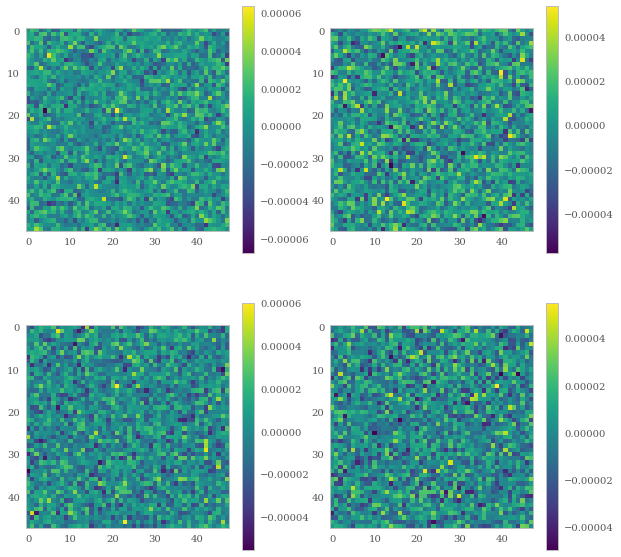

In [34]:
nfields = 1
ngals_per_field = 4

nx = ny = 48

fig = plt.figure(figsize=(10, 10))

bias = np.zeros((nfields, 2), dtype=np.float64)
for ifield in xrange(nfields):
    for igal in xrange(ngals_per_field):
        img = load_footprint(ifield, igal)
#         print img.shape
        true_shears, true_params = get_truths(ifield, igal)
        # -----
        rstr = jiffy.Roaster()
        rstr.ngrid_x = nx
        rstr.ngrid_y = ny
#         rstr.noise_var = 1.404e-9
        rstr.src_models[0].params[0].dx = true_params[0]
        rstr.src_models[0].params[0].dy = true_params[1]
        rstr.src_models[0].set_params(true_shears)
        rstr.data = img
        print rstr.src_models[0].params
        # -----
        model = rstr._get_model_image()
        plt.subplot(2, 2, igal+1)
        plt.imshow(rstr.data - model.array)
        plt.colorbar()
        # -----
#         shear_val = true_shears[1]
#         shears = np.linspace(shear_val - 0.02, shear_val + 0.02, 100)
#         lnp = np.array([rstr([true_shears[0], g_val]) for g_val in shears])
#         plt.plot(shears, lnp)
#         popt, _ = fit_gaussian(shears, lnp)
#         bias[ifield, 0] += popt[1] - shear_val
#         bias[ifield, 1] += popt[2]
    bias[ifield, :] /= ngals_per_field
print bias